In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_style('ticks')

In [24]:
DATA_PATH = Path('../data/cleaned')

fact_events = DATA_PATH / 'fact_events_cleaned.parquet'
fact_products = DATA_PATH / 'fact_product_cleaned.parquet'

df_events = pd.read_parquet(fact_events)
df_products = pd.read_parquet(fact_products)

---
## 1️⃣Where do users drop off the most in the purchase funnel?

---

In [26]:
funnel = [
    'view_item'    
    ,'add_to_cart'   
    ,'begin_checkout'   
    ,'add_shipping_info'   
    ,'add_payment_info'   
    ,'purchase'   
]

funnel_events = (
    df_events[df_events['event_name'].isin(funnel)]
    .groupby('event_name',observed=True)['user_id']
    .nunique()
    .reindex(funnel)
    .reset_index()
)  

funnel_events.columns = ['stage', 'user_count']


funnel_events['drop_off_pct'] = (
    1 - (funnel_events['user_count'] / funnel_events['user_count'].shift(1))
)

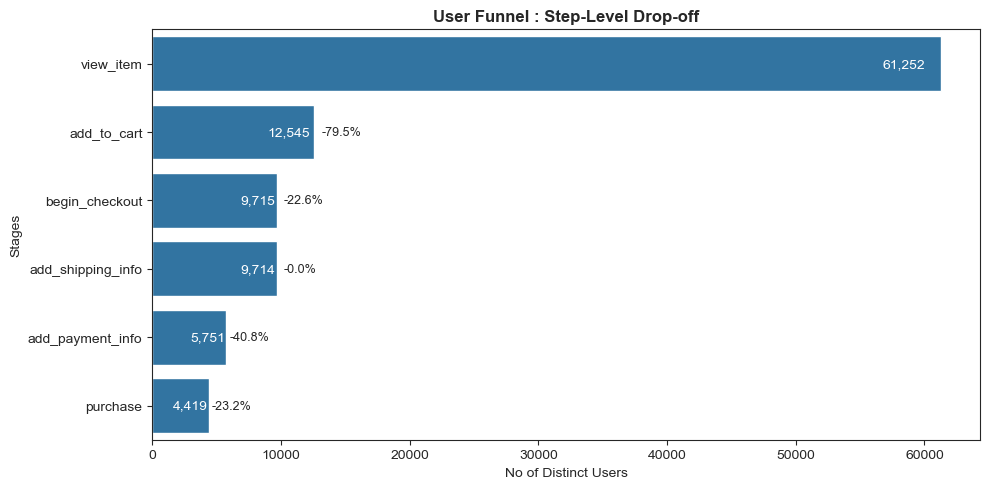

In [50]:
plt.figure(figsize = (10,5))
sns.barplot(
    data=funnel_events,
    y='stage',
    x='user_count',
)

for i, row in funnel_events.iterrows():
    plt.text(
        row['user_count'] * .98,
        i,
        f"{row['user_count']:,}",
        va = 'center',
        ha = 'right',
        color = 'white'
    )
    if row['drop_off_pct'] > 0:
        plt.text(
            row['user_count'] * 1.05,
            i,
            f"-{row['drop_off_pct']:.1%}",
            va = 'center',
            fontsize = 9
        )
plt.title('User Funnel : Step-Level Drop-off',fontweight='bold')
plt.ylabel('Stages')
plt.xlabel('No of Distinct Users')
plt.tight_layout()
plt.show()

---
## 2️⃣Are users failing more at product decisions or during checkout?
---

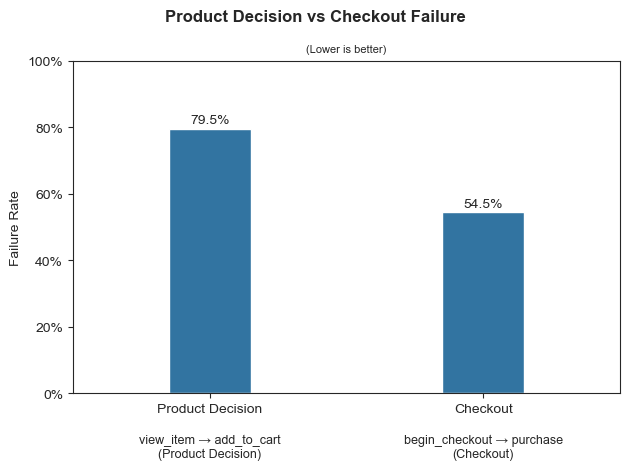

In [61]:
friction = funnel_events.copy()
s = friction.set_index('stage')['user_count']
decision_failure = 1 - s['add_to_cart'] / s['view_item']
checkout_failure = 1 - s['purchase'] / s['begin_checkout']

failure = pd.DataFrame({
    'failure_stage': ['Product Decision','Checkout'],
    'failure_rate': [decision_failure,checkout_failure]
})

sns.barplot(
    data =failure,
    x= 'failure_stage',
    y= 'failure_rate',
    width = .3
)
plt.suptitle('Product Decision vs Checkout Failure',fontweight='bold', fontsize=12)
plt.title('(Lower is better)', fontweight='light', fontsize=8)
plt.ylabel('Failure Rate')
plt.xlabel('')
plt.ylim(0,1)


for i, row in failure.iterrows():
    plt.text(
        i,                         
        row['failure_rate'] * 1.01,       
        f"{row['failure_rate']:.1%}",
        ha='center',
        va='bottom',
        fontsize=10
    )
plt.text(
    0,
    -0.12,
    'view_item → add_to_cart\n(Product Decision)',
    ha='center',
    va='top',
    fontsize=9
)

plt.text(
    1,
    -0.12,
    'begin_checkout → purchase\n(Checkout)',
    ha='center',
    va='top',
    fontsize=9
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.tight_layout()
plt.show()



---
## 3️⃣How many users actually show purchase intent vs just browsing?
---

In [29]:
intent_events = [
    'view_item',
    'add_to_cart',
    'begin_checkout',
    'purchase'
]

user_intents = df_events[df_events['event_name'].isin(intent_events)].copy()
user_intents = (user_intents.groupby(['user_id','event_name'], observed = True)
                .size()
                .unstack(fill_value=0)
                .reset_index()
                
)

def classify_intent(row):
    if row.get('purchase',0) > 0:
        return 'Converted'
    elif row.get('add_to_cart',0) > 0 or row.get('begin_checkout',0) > 0:
        return 'High Intent'
    else:
        return 'Browsing'

user_intents['intent_type'] = user_intents.apply(classify_intent, axis = 1)

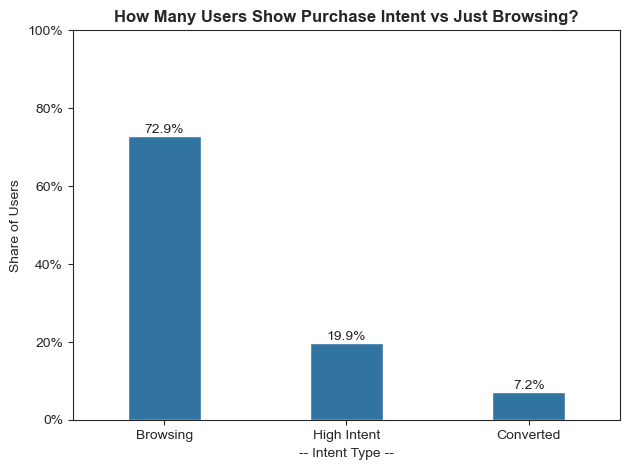

In [60]:
intent_summary = (
    user_intents['intent_type']
    .value_counts()
    .reset_index()
)

intent_summary.columns = ['intent_type', 'users']
intent_summary['share'] = intent_summary['users'] / intent_summary['users'].sum()

sns.barplot(
    data = intent_summary,
    x= 'intent_type',
    y = 'share',
    width = .4
)

for i, row in intent_summary.iterrows():
    plt.text(
        i,
        row['share'],
        f"{row['share']:.1%}",
        va= 'bottom',
        ha= 'center'
    )
plt.ylim(0,1)
plt.title("How Many Users Show Purchase Intent vs Just Browsing?",fontweight='bold')
plt.xlabel('-- Intent Type --')
plt.ylabel('Share of Users')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

---
## 4️⃣Which traffic sources bring high-intent users, not just volume?
---

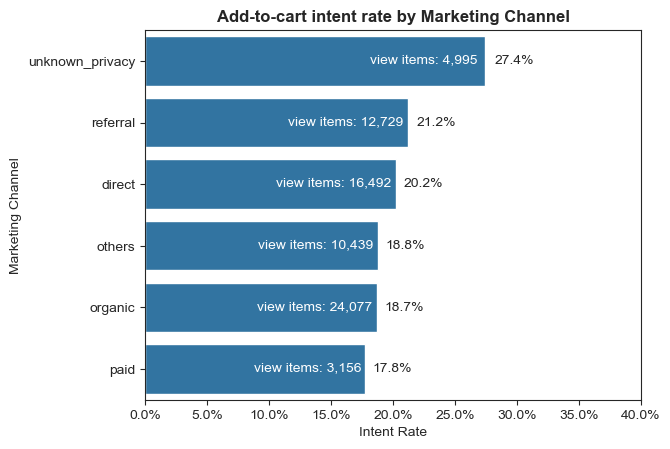

In [67]:
channel_intent = df_events[df_events['event_name'].isin(['view_item','add_to_cart'])].copy()
channel_intent = (
    channel_intent.groupby(['marketing_channel','event_name'] ,observed = True)['user_id']
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)
channel_intent['intent_rate'] = channel_intent['add_to_cart'] / channel_intent['view_item']
channel_intent = channel_intent.sort_values('intent_rate',ascending=True).reset_index()

sns.barplot(
    data=channel_intent,
    y='marketing_channel',
    x='intent_rate',
    order = channel_intent['marketing_channel']
)
for i ,row in channel_intent.iterrows():
    plt.text(
        row['intent_rate'] * .98,
        i,
        f"view items: {row['view_item']:,}",
        va= 'center',
        ha = 'right',
        color = 'white'   
    )
    plt.text(
        row['intent_rate']* 1.03,
        i,
        f"{row['intent_rate']:.1%}",
        ha='left',
        va='center'
    )
plt.xlim(0,.4)
plt.title('Add-to-cart intent rate by Marketing Channel',fontweight='bold')
plt.ylabel('Marketing Channel')
plt.xlabel('Intent Rate')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()


---
## 5️⃣How does engagement relate to conversion?
---

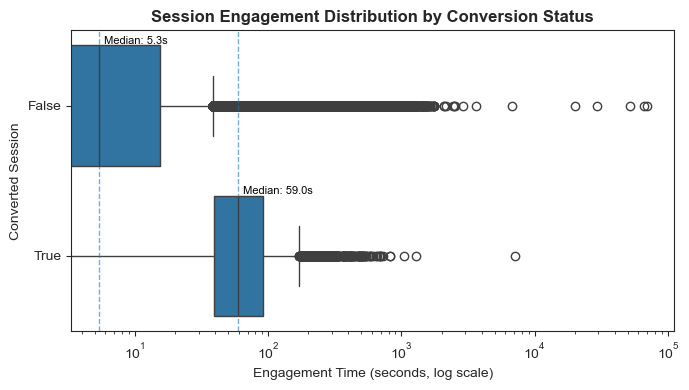

In [53]:
session_engagement = df_events.groupby('session_id',observed=True)['engagement_time_msec'].quantile(.99).reset_index().copy()

converted_session = set(
    df_events[df_events['event_name'] == 'purchase']['session_id']
)
session_engagement['converted'] = session_engagement['session_id'].isin(converted_session)
session_engagement['engagement_seconds'] = (
    session_engagement['engagement_time_msec'] / 1000
)
plt.figure(figsize=(7, 4))
sns.boxplot(
    data=session_engagement,
    x='engagement_seconds',
    y='converted',
    orient = 'h',
    
)
medians = (
    session_engagement
    .groupby('converted',observed=True)['engagement_seconds']
    .median()
)

for i, (conv, median) in enumerate(medians.items()):
    plt.axvline(
        median,
        linestyle='--',
        linewidth=1,
        alpha=0.6
    )
    plt.text(
        median * 1.1,
        i - .41,
        f"Median: {median:.1f}s",
        fontsize=8,
        ha='left',
        color='black'
    )

plt.xscale('log')
plt.xlabel('Engagement Time (seconds, log scale)')
plt.ylabel('Converted Session')
plt.title('Session Engagement Distribution by Conversion Status',fontweight='bold')

plt.tight_layout()
plt.show() 

---
## 6️⃣Which traffic sources drive consistent conversions over time?
---

In [33]:
daily_purchases = df_events[df_events['event_name']== 'purchase'].copy()

daily_purchases = (
    daily_purchases.groupby(['event_date','marketing_channel'],observed=True)['user_id']
    .nunique()
    .reset_index(name='conversions')
)

daily_purchases['smooth'] = (
    daily_purchases.groupby('marketing_channel',observed=True)['conversions']
    .transform(lambda x: x.rolling(7, min_periods=1).mean()) 
)
channel_stability = (
    daily_purchases.groupby('marketing_channel',observed=True)['conversions']
    .agg(mean = 'mean', std = 'std')
    .reset_index()
)

channel_stability['cv'] = channel_stability['std'] / channel_stability['mean']
channel_stability.sort_values(by='cv')
daily_purchases

,event_date,marketing_channel,conversions,smooth
0,2020-11-01,direct,5,5.000000
1,2020-11-01,organic,2,2.000000
2,2020-11-01,others,1,1.000000
3,2020-11-01,referral,4,4.000000
4,2020-11-01,unknown_privacy,1,1.000000
...,...,...,...,...
520,2021-01-31,direct,7,12.000000
521,2021-01-31,organic,4,10.142857
522,2021-01-31,others,4,4.142857
523,2021-01-31,referral,1,10.571429


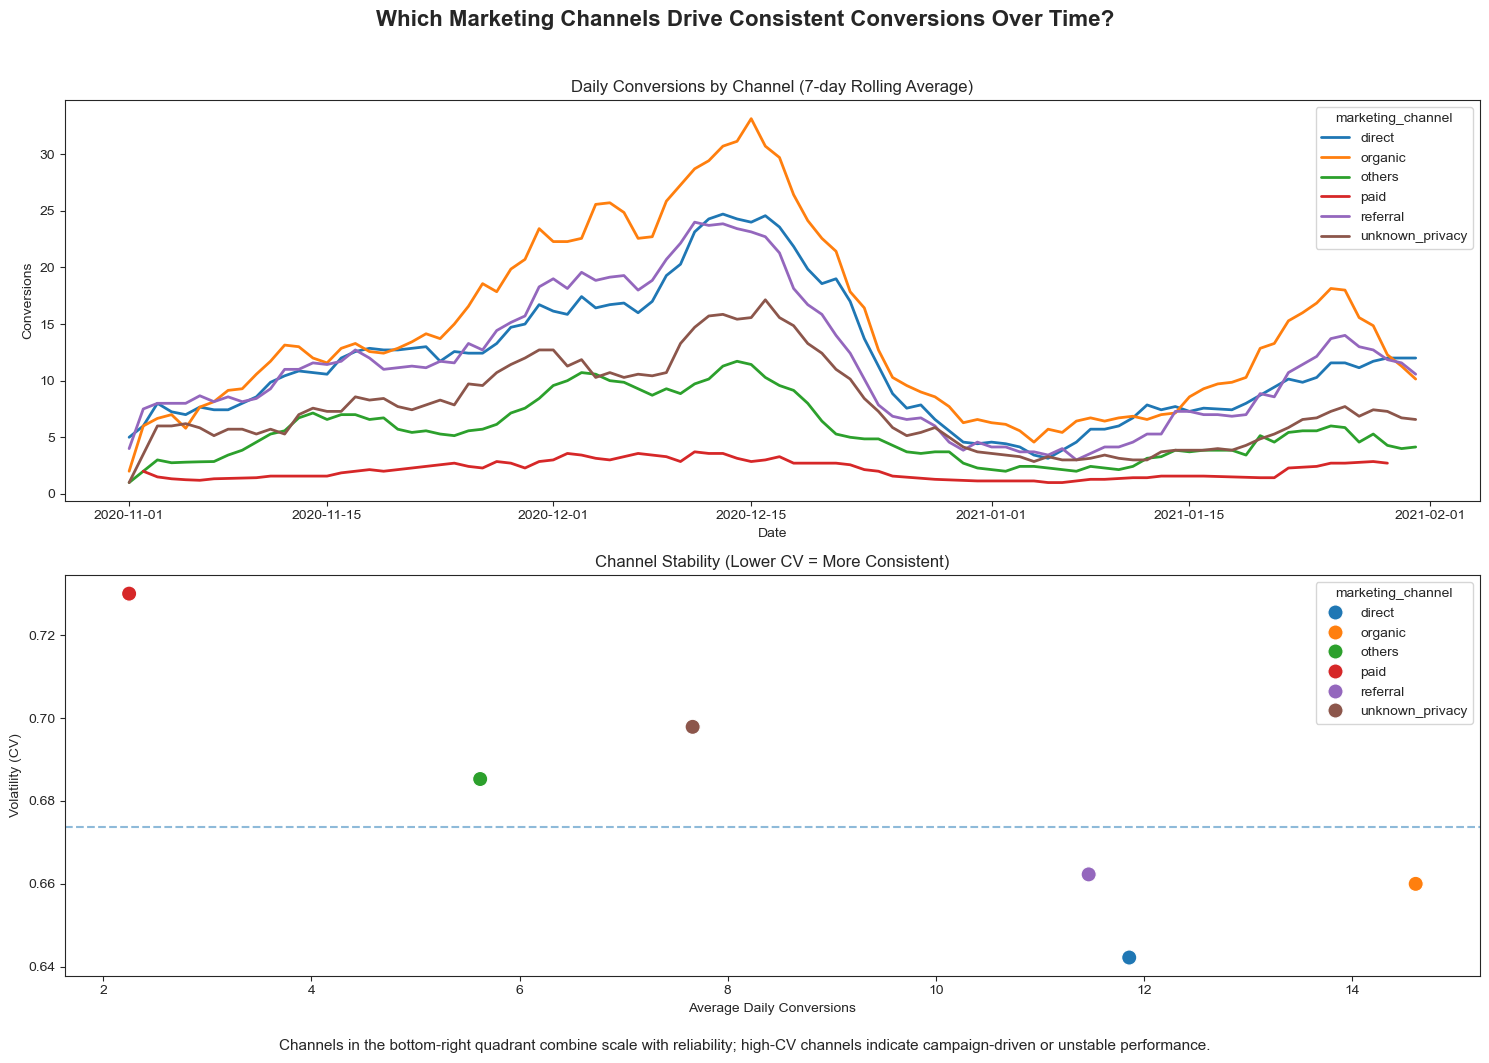

In [41]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

sns.lineplot(
    data=daily_purchases,
    x='event_date',
    y='smooth',
    hue='marketing_channel',
    ax=ax[0],
    linewidth=2,
    
)
ax[0].set_title('Daily Conversions by Channel (7-day Rolling Average)')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Conversions')
sns.scatterplot(
    data=channel_stability,
    x='mean',
    y='cv',
    ax=ax[1],
    hue='marketing_channel',
    s=120
)
ax[1].axhline(channel_stability['cv'].median(), linestyle='--', alpha=0.5)
ax[1].set_title('Channel Stability (Lower CV = More Consistent)')
ax[1].set_xlabel('Average Daily Conversions')
ax[1].set_ylabel('Volatility (CV)')
fig.suptitle(
    "Which Marketing Channels Drive Consistent Conversions Over Time?",
    fontsize=16,
    fontweight='bold',
    y=1.02
)
fig.text(
    0.5, -0.02,
    "Channels in the bottom-right quadrant combine scale with reliability; high-CV channels indicate campaign-driven or unstable performance.",
    ha='center',
    fontsize=11
)
plt.tight_layout()

---
## 7️⃣Which Product Types Convert Views into Cart Adds?
---

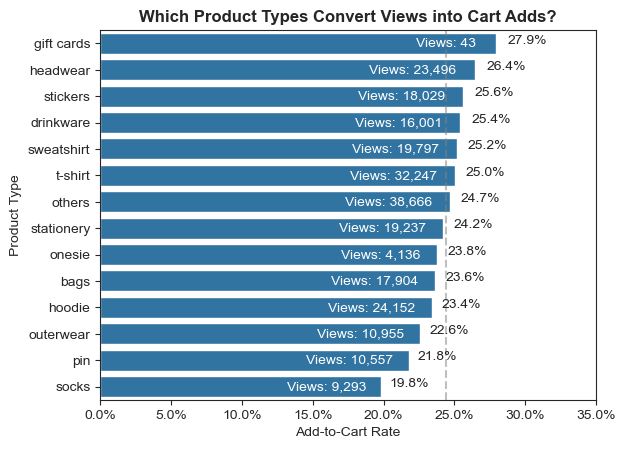

In [56]:
product_strength = df_products.copy()
product_strength = (product_strength[product_strength['event_name'].isin(['view_item',"add_to_cart"])]
                    .groupby(['product_type','event_name'],observed=True)['user_id']
                    .nunique()
                    .unstack(fill_value=0)
)
product_strength['cart_rate'] = product_strength['add_to_cart'] / product_strength['view_item']
product_strength = product_strength.sort_values('cart_rate',ascending=False).reset_index()

sns.barplot(
    data=product_strength,
    x='cart_rate',
    y='product_type',
    order=product_strength['product_type']
)
for i,row in product_strength.iterrows():
    plt.text(
        row['cart_rate']* .95,
        i,
        f"Views: {row['view_item']:,}",
        ha='right',
        va='center',
        color='white'

    )
    plt.text(
        row['cart_rate']* 1.03,
        i,
        f"{row['cart_rate']:.1%}"
    )
plt.axvline(product_strength['cart_rate'].median(), linestyle='--', alpha=0.5,color='grey')
plt.title("Which Product Types Convert Views into Cart Adds?",fontweight='bold')
plt.xlabel("Add-to-Cart Rate")
plt.ylabel("Product Type")
plt.xlim(0,.35)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))


---
## 8️⃣Brand X Audience → which converts better?

---

In [36]:
brand_audience = df_products[df_products['event_name'].isin(['view_item','add_to_cart','purchase'])].copy()
brand_audience = (
    brand_audience.groupby(['target_segment','event_name'], observed = True)['user_id']
    .nunique()
    .unstack(fill_value=0)
    
)

brand_audience['purchase_rate'] = brand_audience['purchase'] / brand_audience['view_item']
brand_audience['addtocart_rate'] = brand_audience['add_to_cart'] / brand_audience['view_item']

brand_audience = brand_audience.sort_values('addtocart_rate',ascending=False).reset_index()

brand_performance = df_products[df_products['event_name'].isin(['view_item','add_to_cart','purchase'])].copy()
brand_performance = (
    brand_performance.groupby(['brand','event_name'], observed = True)['user_id']
    .nunique()
    .unstack(fill_value=0)
    
)

brand_performance['purchase_rate'] = brand_performance['purchase'] / brand_performance['view_item']
brand_performance['addtocart_rate'] = brand_performance['add_to_cart'] / brand_performance['view_item']
brand_performance = brand_performance.sort_values('addtocart_rate',ascending=False).reset_index()
brand_performance


event_name,brand,add_to_cart,purchase,view_item,purchase_rate,addtocart_rate
0,android,8946,711,31606,0.022496,0.283048
1,#iamremarkable,3346,155,11905,0.013020,0.281058
2,google,11867,4174,43082,0.096885,0.275451
3,youtube,7470,373,28222,0.013217,0.264687


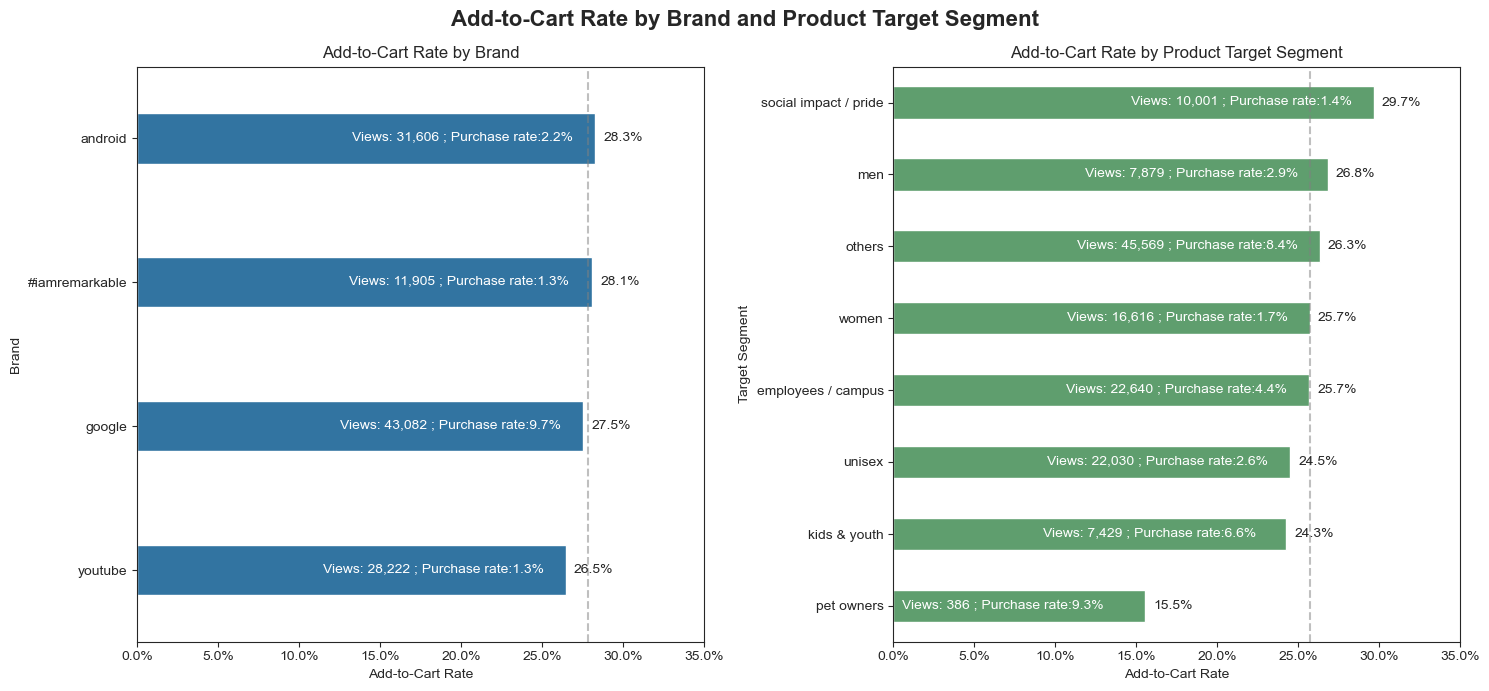

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# --- Left: Brand performance ---
sns.barplot(
    data=brand_performance,
    x='addtocart_rate',
    y='brand',
    ax=ax[0],
    order=brand_performance['brand'],
    width=0.35,
)

for i, row in brand_performance.iterrows():
    ax[0].text(
        row['addtocart_rate'] + 0.005,
        i,
        f"{row['addtocart_rate']:.1%}",
        va='center',
        fontsize=10
    )
    ax[0].text(
        row['addtocart_rate'] - 0.15,
        i,
        f"Views: {row['view_item']:,} ; Purchase rate:{row['purchase_rate']:.1%}",
        va='center',
        fontsize=10,
        color='white'
    )
for i, row in brand_audience.iterrows():
    ax[1].text(
        row['addtocart_rate'] + 0.005,
        i,
        f"{row['addtocart_rate']:.1%}",
        va='center',
        fontsize=10
    )
    ax[1].text(
        row['addtocart_rate'] - 0.15,
        i,
        f"Views: {row['view_item']:,} ; Purchase rate:{row['purchase_rate']:.1%}",
        va='center',
        fontsize=10,
        color='white'
    )
ax[0].set_xlim(0, .35)
ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[0].set_title("Add-to-Cart Rate by Brand")
ax[0].set_xlabel("Add-to-Cart Rate")
ax[0].set_ylabel("Brand")

# --- Right: Target segment ---
sns.barplot(
    data=brand_audience,
    x='addtocart_rate',
    y='target_segment',
    ax=ax[1],
    order=brand_audience['target_segment'],
    width=0.45,
    color='#55a868'
)

ax[1].set_xlim(0, .35)
ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[1].set_title("Add-to-Cart Rate by Product Target Segment")
ax[1].set_xlabel("Add-to-Cart Rate")
ax[1].set_ylabel("Target Segment")

# --- Benchmark line ---
median_rate1 = brand_performance['addtocart_rate'].median()
median_rate2 = brand_audience['addtocart_rate'].median()
ax[0].axvline(median_rate1, linestyle='--', alpha=0.5, color='gray')
ax[1].axvline(median_rate2, linestyle='--', alpha=0.5, color='gray')
fig.suptitle("Add-to-Cart Rate by Brand and Product Target Segment", fontweight='bold',fontsize=16)
fig.tight_layout()
plt.show()


---
## 9️⃣Distribution of countries showing strong product interest (Add-to-Cart) but weak conversion to purchase?
---

In [38]:
countries = df_products[df_products['event_name'].isin(['view_item','add_to_cart','purchase'])].copy()
countries = (
    countries.groupby(['country','event_name'], observed=True)['user_id']
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)
countries['addtocart_rate'] = countries['add_to_cart'] / countries['view_item']
countries['purchase_rate'] = countries['purchase'] / countries['view_item']
def classify_country(row):
    if row['addtocart_rate'] >= countries['addtocart_rate'].median() and row['purchase_rate'] >= countries['purchase_rate'].median():
        return 'High Interest, High Conversion'
    elif row['addtocart_rate'] >= countries['addtocart_rate'].median() and row['purchase_rate'] < countries['purchase_rate'].median():
        return 'High Interest, Low Conversion'
    elif row['addtocart_rate'] < countries['addtocart_rate'].median() and row['purchase_rate'] >= countries['purchase_rate'].median():
        return 'Low Interest, High Conversion'
    else:
        return 'Low Interest, Low Conversion'

countries['country_segment'] = countries.apply(classify_country, axis=1)
countries.head()

event_name,country,add_to_cart,purchase,view_item,addtocart_rate,purchase_rate,country_segment
0,(not set),90,30,367,0.245232,0.081744,"Low Interest, Low Conversion"
1,Albania,3,1,11,0.272727,0.090909,"High Interest, Low Conversion"
2,Algeria,13,4,32,0.406250,0.125000,"High Interest, High Conversion"
3,Argentina,36,9,121,0.297521,0.074380,"High Interest, Low Conversion"
4,Armenia,1,1,11,0.090909,0.090909,"Low Interest, Low Conversion"


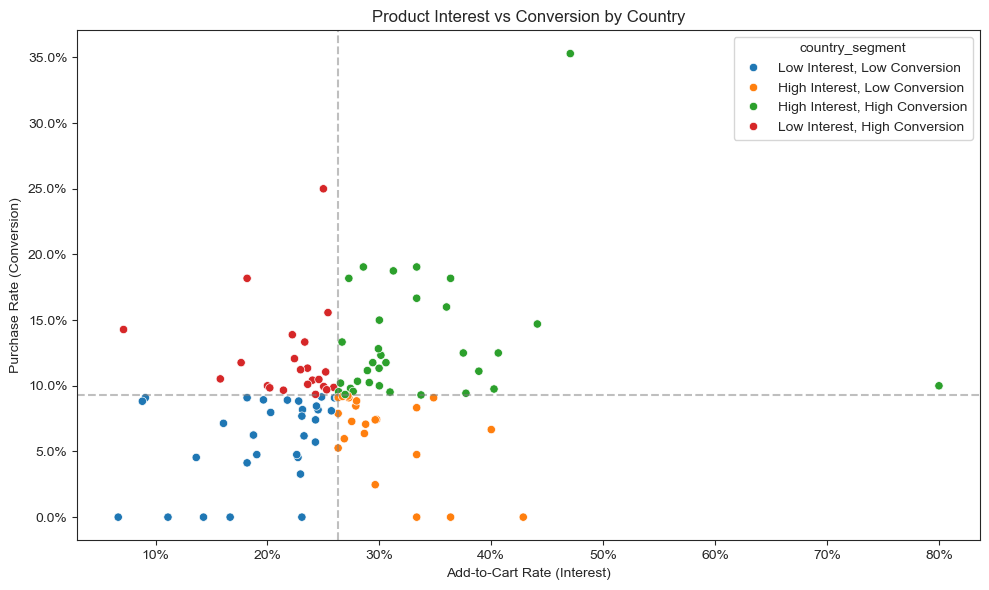

In [39]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=countries,
    x='addtocart_rate',
    y='purchase_rate',
    hue='country_segment'
    
)

plt.axvline(countries['addtocart_rate'].median(),
            linestyle='--', alpha=0.5, color='gray')
plt.axhline(countries['purchase_rate'].median(),
            linestyle='--', alpha=0.5, color='gray')

plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.title("Product Interest vs Conversion by Country")
plt.xlabel("Add-to-Cart Rate (Interest)")
plt.ylabel("Purchase Rate (Conversion)")
plt.tight_layout()
plt.show()